In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import warnings
# importing os module 
import os
# Imports PIL module 
from keras.models import Model
from PIL import Image # for grabbing images
import tensorflow as tf
from itertools import chain #for target labels 
import keras
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [11]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [12]:
# Grab all images 

path_of_input_image_classes="AID"
class_names = os.listdir(path_of_input_image_classes) 
class_names = [i for i in class_names if i != '.DS_Store'] # Gave me an extraneous class, delete it if it appears
num_of_output_classes=len(class_names);
print('Number of classes in total:\n')
print(num_of_output_classes);
class_names.sort()
print('\nTerrain Classes:\n')
print(class_names)
num_of_images_in_classes = []
all_images = []

for dir in class_names:
    filenames = os.listdir(os.path.join(path_of_input_image_classes,dir))
    num_of_images_in_classes.append(len(filenames)) # Stores length of each class
    for file in filenames:
        image = Image.open(os.path.join(path_of_input_image_classes, dir, file))
        image = cv2.imread(os.path.join(path_of_input_image_classes, dir, file))
        image = cv2.resize(image,(214,214))
        all_images.append(image)

Number of classes in total:

3

Terrain Classes:

['Airport', 'BareLand', 'BaseballField']


In [13]:
Images=np.array(all_images) # this is 10,000 images x pixel num x pixel num x RGB val(3)
print(Images.shape)

(845, 214, 214, 3)


In [14]:
# Make target labels
target_labels=[];
class_label=0;
for i in range(num_of_output_classes): # 0 to 29 
    num_of_images_current_class=num_of_images_in_classes[i]
    append_num=[class_label] * num_of_images_current_class
    target_labels.append(append_num)
    class_label=class_label+1
target_labels = list(chain.from_iterable(target_labels))
target_labels=np.array(target_labels)

In [15]:
# Split into training and testing 
X_train, X_test,t_train, t_test = train_test_split(Images,target_labels,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
X_train.shape, X_test.shape, t_train.shape, t_test.shape

((676, 214, 214, 3), (169, 214, 214, 3), (676,), (169,))

In [16]:
def train_transfer_learning_CNN(data_train, labels_train, img_size=214, epochs=5, learning_rate=1e-4):
    
    # load data and labels
    #data_train = np.load(data_train_path)
    #labels_train_temp = np.load(labels_train_path)
    
    # preprocessing
    #gray_scaled=Invert_gray_scale(data_train,300) #Converts all 300x300 images to grey scale
    
    #dilated_data=Dilation(gray_scaled,300) # Dilates all 300x300 images
    
    #bkg_removed_matrix=Remove_bkg_noise(dilated_data,300) #Removes background from 300x300 images
    
    #resized_matrix=resize(bkg_removed_matrix,img_size) #Resizes to img_size x img_size
 
    
    # Normalize data
    X_train = data_train/255 #normalize data [0,1] 
    labels_train = np_utils.to_categorical(labels_train, num_classes=3)
    
    # specify a new input shape to replace VGG16 input layer for our data
    new_input = (img_size, img_size, 3)
    
    # load model
    model = VGG16(include_top=False, input_shape=new_input, pooling='max')
    
    #remove output layer to replace with new one to allow for classification of the 3 classes instead of the original VGG16
    # classification 
    flat1 = Flatten()(model.layers[-1].output) # remove output layer
    class1 = Dense(1024, activation='relu')(flat1) # new dense layer
    output = Dense(3, activation='softmax')(class1) # for 3 classes
    
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    
    # print summary of model
    model.summary()

    # set Adam learning rate
    adam = Adam(lr=learning_rate)

    # We add metrics to get more results you want to see
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # fit model
    print('Training ------------')
    history = model.fit(X_train,labels_train, epochs=epochs)
                
    # plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training'], loc='upper left')
    plt.show()

    # save trained VGG16 CNN model
    model.save('vgg16_trained_cnn.hdf5')

[1 1 0 0 1 1 0 0 2 0 1 1 2 0 2 0 1 1 1 0 1 1 2 0 0 1 2 2 0 1 1 0 1 0 2 1 2
 0 1 2 1 1 1 1 1 2 1 1 1 0 1 1 0 1 1 0 1 2 1 2 0 2 2 1 2 1 1 2 0 2 0 1 2 1
 2 1 0 0 1 0 1 2 1 1 0 2 1 1 0 0 1 2 0 0 2 2 0 0 0 1 1 1 1 2 1 2 0 1 0 0 0
 0 0 2 0 2 2 2 1 1 1 1 1 1 2 1 0 2 0 1 2 2 2 2 0 2 0 2 2 0 1 0 1 0 1 2 2 0
 2 0 0 1 0 1 2 1 1 0 0 1 0 0 2 1 0 1 0 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 0 1 2
 0 1 0 0 1 0 0 0 1 2 1 2 1 1 0 2 0 0 0 1 0 1 1 1 0 1 0 2 2 0 0 0 0 1 0 0 0
 0 1 1 1 1 1 1 0 1 1 1 0 1 2 1 2 1 1 1 1 1 2 2 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 0 1 1 0 2 2 0 2 1 1 2 2 0 2 0 0 0 0 1 0 0 2 2 0 1 1 2 0 1 2 1 1 0 1 1 2 2
 0 0 0 2 1 0 1 1 0 2 0 1 2 1 1 2 1 2 0 2 0 1 1 0 0 0 2 0 1 1 1 1 2 2 0 0 2
 0 0 0 0 1 2 2 1 2 0 0 2 0 1 0 1 1 2 2 1 2 2 2 1 2 2 0 0 0 1 1 1 0 1 1 1 2
 2 2 1 0 0 0 1 2 0 2 2 1 1 0 1 0 0 2 2 1 0 0 1 0 1 2 0 1 0 1 1 2 0 2 0 2 0
 1 2 1 2 1 1 1 0 1 1 0 1 0 2 2 2 1 1 0 1 2 2 0 2 0 2 1 0 0 0 2 0 0 1 1 1 0
 1 1 1 0 0 2 0 0 2 1 2 2 0 0 1 1 2 0 0 1 0 2 1 0 0 0 1 2 0 2 0 0 2 0 0 2 2
 1 1 0 2 2 0 0 1 1 2 0 2 

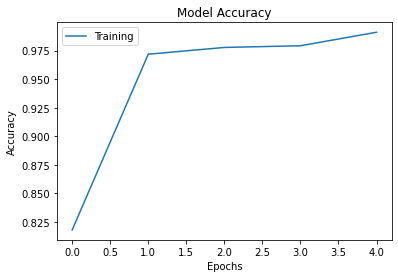

In [17]:
# train VGG16 CNN
train_transfer_learning_CNN(X_train,t_train, img_size=214, epochs=5, learning_rate=1e-4)

In [33]:
def conf_matrix_w_acc(y_test, labels):
    # Evaluate trained model in validation set
    cm = confusion_matrix(y_test, labels)
    acc =np.diagonal(cm).sum()/ cm.sum()
    # acc = accuracy_score(y_test,labels)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True ,fmt='g', xticklabels = class_names, yticklabels = class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix (Accuracy = %f)' % acc, y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [34]:
def test(X_test,labels_test,model_name='vgg16_trained_cnn.hdf5',resized_pixel_size=214): 
        #Get Test Data Information, mainly for clarification on our end 
    
 
        #Reshpaing for input into model 
        X_test = X_test/255.
        
        #Setting up labels for keras model
        labels_test_model = np_utils.to_categorical(labels_test, num_classes=3)

        # Loads trained model 
        model = keras.models.load_model(model_name)

        #Can print model summary for illustration purposes
        #print(model.summary())

        #Evaluating model on test data 
        loss,accuracy=model.evaluate(X_test,labels_test_model)

        #Generates probability matrix of label assignment 
        y_proba = model.predict(X_test)

        #Grabs largest probability for each photo belonging to a certain class 
        y_classes = np.argmax(y_proba,axis=1)

        #Prints confustion matrix 
        print(conf_matrix_w_acc(labels_test, y_classes))
        
        return accuracy,y_classes

6/6 [==============================] - 0s 16ms/step - loss: 0.0631 - accuracy: 0.9822
None


(0.9822485446929932,
 array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0,
        1, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2,
        0, 1, 2, 2, 0, 2, 0, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1, 0, 2,
        2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 2, 2, 1, 1, 2, 1,
        2, 2, 2, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1,
        1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 1,
        1, 0, 2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0]))

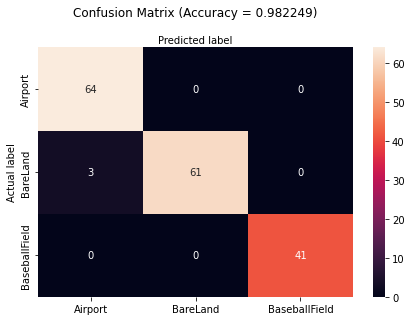

In [35]:
test(X_test,t_test,model_name='vgg16_trained_cnn.hdf5',resized_pixel_size=214)